In [1]:
task_name = 'task3_jenga_openface'

In [2]:
model_path = './models/{0}/'.format(task_name)

# Model Creation for Tasks captured through Openface

1. First we create the training data from the task participant data

       This results in three intermediate training CSVs stored to disk.

2. Next we train the PCA models

        This results in pickled PCA models.
        
3. Then we train a k-means cluster that sits on top of PCA 

        This results in pickled k-means model.

4. Next we train an autoencoder model (as replacement for PCA)

        This results in saved autoencoder model.


In [3]:
import os
import numpy as np
import pandas as pd

import warnings
from tqdm import tqdm_notebook as tqdm

path = './data/openface/{0}'.format(task_name)

files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
print('Num Files:',len(files))

Num Files: 25


## Create training set
Using k out of every file?

Note dropping bad lines

In [4]:
from sklearn.model_selection import train_test_split

indicies = ['frame'] + ['x_{0}'.format(i) for i in range(0,68)] + ['y_{0}'.format(i) for i in range(0,68)]

flag = True
Train = None
Test = None
Valid = None

for f in tqdm(list(files)):
    
    # Load CSV
    print(f)
    df = pd.read_csv(
            os.path.join(path,f), 
            error_bad_lines=False, 
            warn_bad_lines=True)
    
    face_lmk = df[indicies]
    
    # Filter NaN rows
    nans = df[df[indicies].isnull().any(axis=1)]
    if not nans.empty:
        dropList = nans.index.tolist()
        for r in dropList:
            warnings.warn('Dropping row due to NaN, {0}'.format(r))
        face_lmk.drop(dropList, inplace=True)
        
    face_lmk.insert(0,'filename',[f for i in range(0,face_lmk.shape[0])],True)
        
    print('Full:',face_lmk.shape)
    
    # Create Training, Test, Validation subsets
    train, tmp = train_test_split(face_lmk, test_size=0.33)
    test, val = train_test_split(tmp, test_size=0.5)
    print('Train:',train.shape,'Test:',test.shape,'Validation',val.shape)
    
    if flag:
        flag = False
        Train = train
        Test = test
        Valid = val
    else:
        Train = Train.append(train)
        Test = Test.append(test)
        Valid = Valid.append(val)

# Final Dataset (shuffled)
Train = Train.sample(frac=1).reset_index(drop=True)
Test = Test.sample(frac=1).reset_index(drop=True)
Valid = Valid.sample(frac=1).reset_index(drop=True)

print('\n\nFINAL')
print('Train:',Train.shape,'Test:',Test.shape,'Validation',Valid.shape)

0101_Jenga_cut.csv
Full: (8983, 138)
Train: (6018, 138) Test: (1482, 138) Validation (1483, 138)
0201_Jenga_cut.csv
Full: (8636, 138)
Train: (5786, 138) Test: (1425, 138) Validation (1425, 138)
0202_Jenga_cut.csv
Full: (8662, 138)
Train: (5803, 138) Test: (1429, 138) Validation (1430, 138)
0301_Jenga_cut.csv
Full: (9610, 138)
Train: (6438, 138) Test: (1586, 138) Validation (1586, 138)
0302_Jenga_cut.csv
Full: (9629, 138)
Train: (6451, 138) Test: (1589, 138) Validation (1589, 138)
0401_Jenga_cut.csv
Full: (9411, 138)
Train: (6305, 138) Test: (1553, 138) Validation (1553, 138)
0402_Jenga_cut.csv
Full: (9816, 138)
Train: (6576, 138) Test: (1620, 138) Validation (1620, 138)
0501_Jenga_cut.csv
Full: (9179, 138)
Train: (6149, 138) Test: (1515, 138) Validation (1515, 138)
1201_jenga_cut.csv
Full: (9290, 138)
Train: (6224, 138) Test: (1533, 138) Validation (1533, 138)
1202_jenga_cut.csv
Full: (9282, 138)
Train: (6218, 138) Test: (1532, 138) Validation (1532, 138)
1301_jenga_cut.csv
Full: (9455

In [5]:
Train.head()

,filename,frame,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,0401_Jenga_cut.csv,2639,761.6,760.5,762.6,769.5,779.9,791.7,800.3,810.5,...,777.7,772.0,763.3,767.8,770.5,770.1,765.9,768.4,768.3,764.7
1,1501_jenga_cut.csv,7053,612.3,604.2,605.6,615.9,630.5,654.4,679.8,709.7,...,571.9,560.4,537.6,534.8,537.2,536.3,542.6,547.8,547.7,544.5
2,0101_Jenga_cut.csv,423,689.6,700.2,714.6,731.9,750.3,768.7,784.9,800.7,...,460.0,458.8,451.4,447.8,446.3,442.4,430.0,444.2,447.8,449.2
3,0202_Jenga_cut.csv,2862,693.2,701.5,717.2,739.3,762.3,786.6,806.4,829.6,...,735.2,730.6,719.3,720.6,720.0,717.2,703.1,716.2,718.5,718.8
4,0301_Jenga_cut.csv,1692,741.8,744.2,754.1,769.1,784.0,801.2,820.2,844.1,...,970.9,968.7,958.5,952.3,951.5,949.8,951.4,948.7,950.9,951.2


In [6]:
Test.head()

,filename,frame,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,0201_Jenga_cut.csv,762,718.4,724.0,734.8,750.9,766.8,783.6,798.2,811.8,...,457.9,456.7,450.3,446.3,445.5,443.2,432.2,446.2,448.2,448.4
1,1502_jenga_cut.csv,6274,960.2,939.9,923.2,908.2,895.0,888.9,890.2,896.9,...,881.6,863.2,842.4,861.4,871.3,879.8,900.5,882.7,874.7,864.8
2,1801_Jenga Cut .csv,10360,326.6,341.3,361.8,394.2,445.7,518.6,606.0,686.3,...,949.1,953.5,938.3,917.6,913.4,904.3,904.5,905.3,914.1,919.6
3,1201_jenga_cut.csv,4466,721.5,717.0,719.0,727.6,735.5,750.9,765.8,785.9,...,806.9,793.8,777.7,783.3,789.2,792.5,794.7,793.2,789.9,783.7
4,0302_Jenga_cut.csv,7634,994.6,989.5,987.8,990.3,995.6,1004.3,1014.4,1025.4,...,874.5,864.3,852.1,860.1,864.1,866.4,869.4,866.4,864.1,859.8


In [7]:
Valid.head()

,filename,frame,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,Sona_jenga_0301.csv,8345,803.2,799.7,804.6,816.8,835.2,857.8,877.0,899.3,...,699.1,695.6,680.2,669.9,669.3,665.2,665.4,667.1,670.9,671.2
1,1702_Jenga_Cut .csv,2242,693.7,719.8,758.6,793.0,822.3,845.7,843.8,840.4,...,755.2,745.5,727.9,729.7,728.5,721.2,705.1,720.1,726.4,727.6
2,1202_jenga_cut.csv,8442,648.7,643.6,645.8,650.4,654.5,661.4,675.0,695.9,...,787.8,782.5,773.2,771.4,772.7,772.3,775.1,769.2,769.5,768.5
3,Sona0102_jenga_cut.csv,264,999.1,991.0,988.9,992.8,999.0,1010.8,1021.4,1034.8,...,798.8,785.7,769.7,777.2,783.5,787.0,791.2,785.7,782.7,776.2
4,Sona0101_jenga_cut.csv,1140,961.2,964.2,971.3,981.3,993.3,1013.7,1035.1,1061.4,...,846.4,832.1,812.0,816.2,820.9,821.8,822.3,830.6,829.9,824.8


Saving to disk

In [8]:
save_path = './data/tmp_analysis/{0}'.format(task_name)
save_train_path = save_path + '_train.csv'
save_test_path = save_path + '_test.csv'
save_valid_path = save_path + '_valid.csv'


Train.to_csv(save_train_path)
Test.to_csv(save_test_path)
Valid.to_csv(save_valid_path)

## PCA Fit
I found 32 components to be roughly the inflection curve.
I am also creating an 18  component variant just in case we want a direct comparison with action units

In [9]:
import pickle
from sklearn.decomposition import PCA

In [10]:
save_path = './data/tmp_analysis/{0}'.format(task_name)
save_train_path = save_path + '_train.csv'
save_test_path = save_path + '_test.csv'
save_valid_path = save_path + '_valid.csv'


Train = pd.read_csv(save_train_path)
Test = pd.read_csv(save_test_path)
Valid = pd.read_csv(save_valid_path)

In [11]:
X = Train.to_numpy()[:,3:]

In [12]:
pca_n_32 = PCA(n_components=32)
face_pca_n_32 = pca_n_32.fit(X)

print(face_pca_n_32.explained_variance_)

[4.62987008e+06 2.72925026e+06 1.54130997e+05 7.60114385e+04
 4.60983281e+04 2.44411340e+04 2.20384671e+04 7.54351332e+03
 3.89411889e+03 2.03379306e+03 1.64928230e+03 1.51436964e+03
 1.28886970e+03 9.60897665e+02 7.84298071e+02 6.18583204e+02
 4.42432983e+02 3.89113533e+02 3.61640814e+02 3.32080826e+02
 2.67733021e+02 2.32968749e+02 2.16726369e+02 1.77224009e+02
 1.62874174e+02 1.37203905e+02 1.19198114e+02 1.09041395e+02
 1.05150977e+02 8.80905137e+01 8.07716549e+01 6.83802838e+01]


In [13]:
pickle.dump(face_pca_n_32,open(model_path+'pca_n_32.p','wb'))

In [14]:
pca_n_5 = PCA(n_components=5)
face_pca_n_5 = pca_n_5.fit(X)

print(face_pca_n_5.explained_variance_)

[4629870.08163936 2729250.259092    154130.99739267   76011.43849048
   46098.32806381]


In [15]:
pickle.dump(face_pca_n_5,open(model_path+'pca_n_5.p','wb'))

# Autoencoder
Right now just doing a single layer 
Perhaps we can try a two layer encoder / two layer decoder next?

32 Wide encoder

In [16]:
import keras
from keras import layers

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [17]:
X = Train.to_numpy()[:,3:]
Xtest = Test.to_numpy()[:,3:]
Xvalid = Valid.to_numpy()[:,3:]

In [18]:
print(X.shape)

(151068, 136)


In [19]:
input_dim = X.shape[1]
encoding_dim = 32

input_layer = keras.Input(shape=(input_dim,))
encoded_layer = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded_layer = layers.Dense(input_dim, activation='relu')(encoded_layer)

autoencoder_32 = keras.Model(input_layer,decoded_layer)

encoder_32 = keras.Model(input_layer, encoded_layer)

In [20]:
autoencoder_32.compile(optimizer='adam',
                    loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
autoencoder_32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 136)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4384      
_________________________________________________________________
dense_2 (Dense)              (None, 136)               4488      
Total params: 8,872
Trainable params: 8,872
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = autoencoder_32.fit(X, X, epochs=4, batch_size=64, verbose=0, validation_data=(Xtest, Xtest))

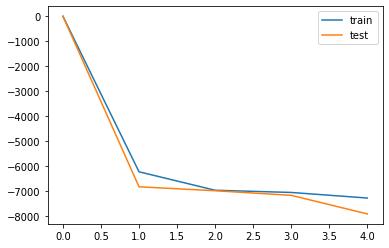

In [23]:
fig, ax = plt.subplots()

plt.plot([0]+history.history['loss'], label='train')
plt.plot([0]+history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
predictions = autoencoder_32.predict(Xvalid)
# TODO I should probably do something with the validation set

In [25]:
autoencoder_32.save(model_path + 'autoencoder_32.pb')
encoder_32.save(model_path + 'encoder_32.pb')

5 wide encoder

In [26]:
import keras
from keras import layers

In [27]:
X = Train.to_numpy()[:,3:]
Xtest = Test.to_numpy()[:,3:]
Xvalid = Valid.to_numpy()[:,3:]

In [28]:
input_dim = X.shape[1]
encoding_dim = 5

input_layer = keras.Input(shape=(input_dim,))
encoded_layer = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded_layer = layers.Dense(input_dim, activation='relu')(encoded_layer)

autoencoder_5 = keras.Model(input_layer,decoded_layer)

encoder_5 = keras.Model(input_layer, encoded_layer)

In [29]:
autoencoder_5.compile(optimizer='adam',
                    loss='binary_crossentropy')

In [30]:
autoencoder_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 136)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 685       
_________________________________________________________________
dense_4 (Dense)              (None, 136)               816       
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = autoencoder_5.fit(X, X, epochs=3, batch_size=64, verbose=0, validation_data=(Xtest, Xtest))

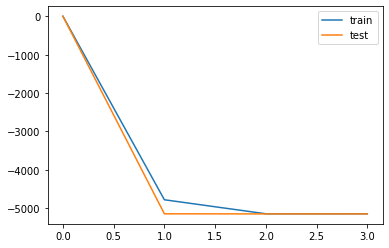

In [32]:
fig, ax = plt.subplots()

plt.plot([0]+history.history['loss'], label='train')
plt.plot([0]+history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
predictions = autoencoder_5.predict(Xvalid)
# TODO I should probably do something with the validation set

In [34]:
autoencoder_5.save(model_path + 'autoencoder_5.pb')
encoder_5.save(model_path + 'encoder_5.pb')

## K-means
Not sure what this is going to do 
(my guess is it is going to cluster similar participants)

In [35]:
import matplotlib.pyplot as plt

def visualize_labels(y):
    idx = np.arange(len(y))

    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)

    ax1.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto")
    ax1.set_yticks([])

    ax2.scatter(idx,y)

    plt.tight_layout()
    plt.show()

In [36]:
from sklearn.cluster import KMeans

In [37]:
X_pca = face_pca_n_32.transform(X)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(X_pca)

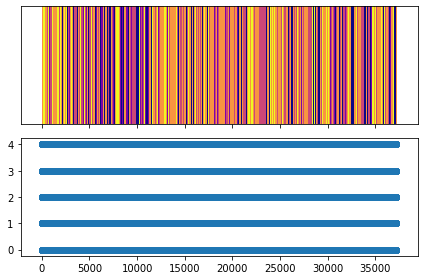

In [38]:
y = kmeans_5.predict(face_pca_n_32.transform(Test.to_numpy()[:,3:]))
visualize_labels(y)

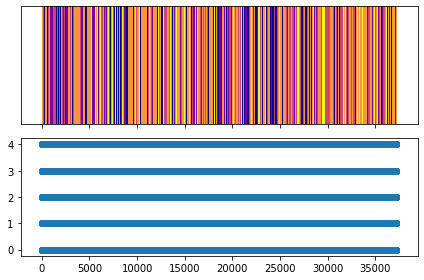

In [39]:
y = kmeans_5.predict(face_pca_n_32.transform(Valid.to_numpy()[:,3:]))
visualize_labels(y)

In [40]:
pickle.dump(kmeans_5,open(model_path+'kmeans_5_from_pca.p','wb'))

In [41]:
X_auto = encoder_32.predict(X)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(X_auto)

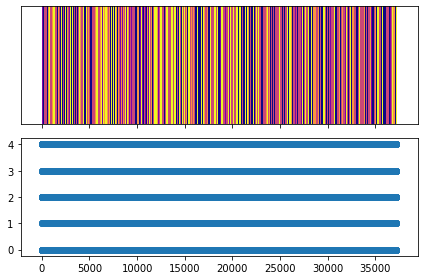

In [42]:
y = kmeans_5.predict(encoder_32.predict(Test.to_numpy()[:,3:]))
visualize_labels(y)

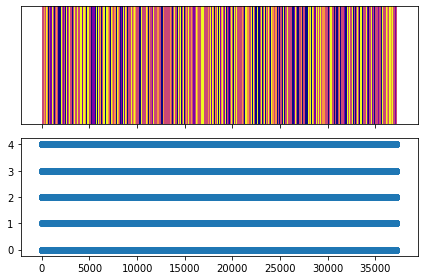

In [43]:
y = kmeans_5.predict(encoder_32.predict(Valid.to_numpy()[:,3:]))
visualize_labels(y)

In [44]:
pickle.dump(kmeans_5,open(model_path+'kmeans_5_from_auto.p','wb'))

## Model Comparisons
Is there some way to perform a comparison across the models
- PCA-n-5
- PCA-n-32 -> KMeans-5-from-pca
- Autoencoder-32 -> KMeans-5-from-autoencoder
- Autoencoder-5